TODO  
 * errors per day / station heatmap / per model

In [63]:
import pandas as pd
import numpy as np
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'../')
from utils.utils import *

import yaml
import argparse

In [64]:
AT = 5

def get_list_common_date(start, end, obs, list_df_pred):
    df = obs[['Datetime']].set_index('Datetime')[start:end]
    df = df.join([df_[['Datetime']].set_index('Datetime') for df_ in list_df_pred])
    return df.index.values.astype(str)


def mse(obs, pred):
    return ((pred - obs) ** 2).mean()


def rmse(obs, pred):
    return np.sqrt(mse(obs, pred))


def mae(obs, pred):
    return np.absolute(pred - obs).mean()


def mape_at(obs, pred):
    mask = obs >= AT
    return (np.absolute(pred[mask] - obs[mask]) / obs[mask]).mean()


def get_errors(obs, list_df_pred, list_name_pred, list_date, errors=[rmse, mae, mse, mape_at],
               errors_name=['rmse', 'mae', 'mse', 'mape_at' + str(AT)], ):
    data = []
    columns = ['model'] + errors_name
    obs = obs.set_index('Datetime').loc[list_date].values
    for df, name in zip(list_df_pred, list_name_pred):
        pred = df.set_index('Datetime').loc[list_date].values
        data.append([name] + [e(obs, pred).mean() for e in errors])
    return pd.DataFrame(data, columns=columns)


def error_per_station(obs, list_df_pred, list_name_pred, list_date, error=mape_at):
    data = []
    columns = ['__time_series__'] + list(obs.columns.values[1:])
    obs = obs.set_index('Datetime').loc[list_date].values
    for df, name in zip(list_df_pred, list_name_pred):
        pred = df.set_index('Datetime').loc[list_date].values
        data.append([name] + [error(obs[:, i], pred[:, i]) for i in range(pred.shape[1])])
    df = pd.DataFrame(data, columns=columns).set_index('__time_series__').T.reset_index()
    df.columns = np.array(['__time_series__'] + df.columns[1:].values.tolist()).astype(str)
    df['__index__'] = np.arange(len(df))
    return df


In [65]:
#variables start

start_date_train = '2015'
end_date_train = '2017'
start_date_test = '2017'
end_date_test = '2018'
file_path_obs = ['/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass.csv']
file_path_pred = ['/home/toque/data2/forecast/model/ha/prediction/ha_mtl_metro_day/2015-01-01_2017-12-31_mean.csv',
                  '/home/toque/data2/forecast/model/rf/prediction/rf_lt_mtl/2015-01-01_2017-12-31.csv']
list_name_pred = ['ha', 'rf_lt']
time_series = ['11', '32', '34', '15', '44', '65', '31', '33', '35', '47', '13', '14', '1', '9', '5', '18',
               '36', '24', '68', '43', '8', '64', '10', '55', '3', '49', '51', '2', '19', '56', '7', '6',
               '4', '48', '66', '25', '23', '28', '39', '54', '60', '27', '20', '46', '12', '21', '62', '52',
               '41', '50', '30', '16', '37', '40', '26', '67', '57', '61', '42', '45', '38', '29', '58', 
               '63', '22', '59', '53', '17']
time_series_name = ['Station Berri-UQAM', 'Station McGill', 'Station Guy-Concordia', 'Station Bonaventure',
                    'Station Longueuil-Université-de-Sherbrooke', 'Station Côte-Vertu', 'Station Place-des-Arts',
                    'Station Peel','Station Atwater', 'Station Vendôme', "Station Place-d'Armes",
                    'Station Square-Victoria-OACI', 'Station Henri-Bourassa', 'Station Mont-Royal',
                    'Station Jean-Talon','Station Honoré-Beaugrand', 'Station Lionel-Groulx', 'Station Pie-IX', 
                    'Station Montmorency', 'Station Angrignon', 'Station Laurier', 'Station Saint-Michel', 
                    'Station Sherbrooke', 'Station Côte-des-Neiges', 'Station Crémazie', 'Station Snowdon',
                    'Station Plamondon', 'Station Sauvé', 'Station Radisson', 'Station Université-de-Montréal',
                    'Station Rosemont', 'Station Beaubien', 'Station Jarry', 'Station Villa-Maria', 'Station Cartier',
                    'Station Joliette', 'Station Viau', 'Station Papineau', "Station De l'Église",
                    'Station Du Collège','Station Parc', 'Station Frontenac', 'Station Langelier',
                    'Station Place-Saint-Henri', 'Station Champ-de-Mars', 'Station Cadillac', 'Station Fabre',
                    'Station Namur', 'Station Jolicoeur', 'Station Côte-Sainte-Catherine', 'Station Saint-Laurent',
                    "Station Lucien-L'Allier", 'Station Charlevoix', 'Station Verdun', 'Station Préfontaine',
                    'Station De la Concorde', 'Station Édouard-Montpetit', 'Station De Castelnau', 'Station Monk', 
                    'Station Jean-Drapeau', 'Station LaSalle', 'Station Beaudry', 'Station Outremont',
                    "Station D'Iberville", 'Station Assomption', 'Station Acadie', 'Station De la Savane',
                    'Station Georges-Vanier']
directory_path_to_save =  "/home/toque/data2/forecast/evaluation/"
name_evaluation = 'eval_forecast_mtl_metro'

parser = argparse.ArgumentParser(description='Parameters of script predict')
parser.add_argument('--config', type=str, help='Yaml file containing the configuration of the evaluation')
parser.add_argument('--force', type=bool, help='Boolean: If True force all the saving, if False ask to the user',
                    default=False)
args = parser.parse_args()
config_file = args.config

with open(config_file, 'r') as stream:
    try:
        config = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)


start_date_train = config['start_date_train']
end_date_train = config['end_date_train']
start_date_test = config['start_date_test']
end_date_test = config['end_date_test']
file_path_obs = config['file_path_obs']
file_path_pred = config['file_path_pred']
list_name_pred = config['list_name_pred']
time_series = config['time_series']
time_series_name = config['time_series_name']
if time_series_name != None:
    try:
        time_series_name = [i.decode('utf-8') for i in time_series_name]
    except:
        time_series_name = config['time_series_name']
directory_path_to_save = config['directory_path_to_save']
name_evaluation = config['name_evaluation']

print(time_series_name)
assert (start_date_train != None) & (end_date_train != None) & (start_date_test != None) & (end_date_test != None) &\
       (file_path_obs != None) & (file_path_pred != None) & (list_name_pred != None) & (time_series != None) &\
       (directory_path_to_save != None) & (name_evaluation != None),\
    'Configuration is not well defined, every variable have to be different of None'


In [66]:

print('Read observation and prediction files..')

obs = read_csv_list(file_path_obs)[['Datetime'] + time_series]
list_df_pred = [read_csv_list([f])[['Datetime'] + time_series] for f in file_path_pred]


print('Evaluate (1/2) global errors..')

for df in list_df_pred:
    assert ((df.columns != obs.columns.values).sum() == 0)

list_date_train = get_list_common_date(start_date_train, end_date_train, obs, list_df_pred)
list_date_test = get_list_common_date(start_date_test, end_date_test, obs, list_df_pred)

df_train_errors = get_errors(obs, list_df_pred, list_name_pred, list_date_train,
                             errors_name=['rmse', 'mae', 'mse', 'mape_at' + str(AT)])
df_test_errors = get_errors(obs, list_df_pred, list_name_pred, list_date_test,
                            errors_name=['rmse', 'mae', 'mse', 'mape_at' + str(AT)])

if not False:
    if not os.path.exists(directory_path_to_save + name_evaluation + '/'):
        os.makedirs(os.path.dirname(directory_path_to_save + name_evaluation + '/'))
    elif not yes_or_no("Folder " + name_evaluation + " already exists. Do you want to continue?"):
        sys.exit()


#df_train_errors.to_csv(directory_path_to_save + name_evaluation + "/errors_trainset.csv", index=False)
#df_test_errors.to_csv(directory_path_to_save + name_evaluation + "/errors_testset.csv", index=False)


print('Evaluate (2/2) errors per time-series..')

df_train_error_per_station = error_per_station(obs, list_df_pred, list_name_pred, list_date_train, error=mape_at)
df_test_error_per_station = error_per_station(obs, list_df_pred, list_name_pred, list_date_test, error=mape_at)

if time_series_name != None:
    dict_id_name = dict(zip(time_series, time_series_name))
    df_train_error_per_station['__time_series__'] = [dict_id_name[i] for i in
                                                     df_train_error_per_station['__time_series__'].values]
    df_test_error_per_station['__time_series__'] = [dict_id_name[i] for i in
                                                    df_test_error_per_station['__time_series__'].values]


sns.set_style('whitegrid')
ax = plt.gca()
kind = 'scatter'

f = df_train_error_per_station.plot(figsize=(20, 4), kind=kind, x='__index__', y=list_name_pred[0], ax=ax)
for m in list_name_pred[1:]:
    f = df_train_error_per_station.plot(kind=kind, x='__index__', y=m, ax=ax, color='red')
f.set_xticks(df_train_error_per_station['__index__'])
f.set_xticklabels(df_train_error_per_station['__time_series__'], rotation=90)
f.set_xlabel('Time-series')
f.set_ylabel('MAPE@' + str(AT))

ax.legend(list_name_pred)
fig = f.get_figure()
#fig.savefig(directory_path_to_save + name_evaluation + "/errors_trainset_per_time_series.png", bbox_inches='tight')


sns.set_style('whitegrid')
ax = plt.gca()
kind = 'scatter'

f = df_test_error_per_station.plot(figsize=(20, 4), kind=kind, x='__index__', y=list_name_pred[0], ax=ax)
for m in list_name_pred[1:]:
    f = df_test_error_per_station.plot(kind=kind, x='__index__', y=m, ax=ax, color='red')
f.set_xticks(df_test_error_per_station['__index__'])
f.set_xticklabels(df_test_error_per_station['__time_series__'], rotation=90)
f.set_xlabel('Time-series')
f.set_ylabel('MAPE@' + str(AT))

ax.legend(list_name_pred)
fig = f.get_figure()
#fig.savefig(directory_path_to_save + name_evaluation + "/errors_testset_per_time_series.png", bbox_inches='tight')


print('Evaluation done')

Read observation and prediction files..
Evaluate (1/2) global errors..
Folder eval_forecast_mtl_metro already exists. Do you want to continue? (y/n): y
Evaluate (2/2) errors per time-series..
Evaluation done


In [67]:
plt.close()

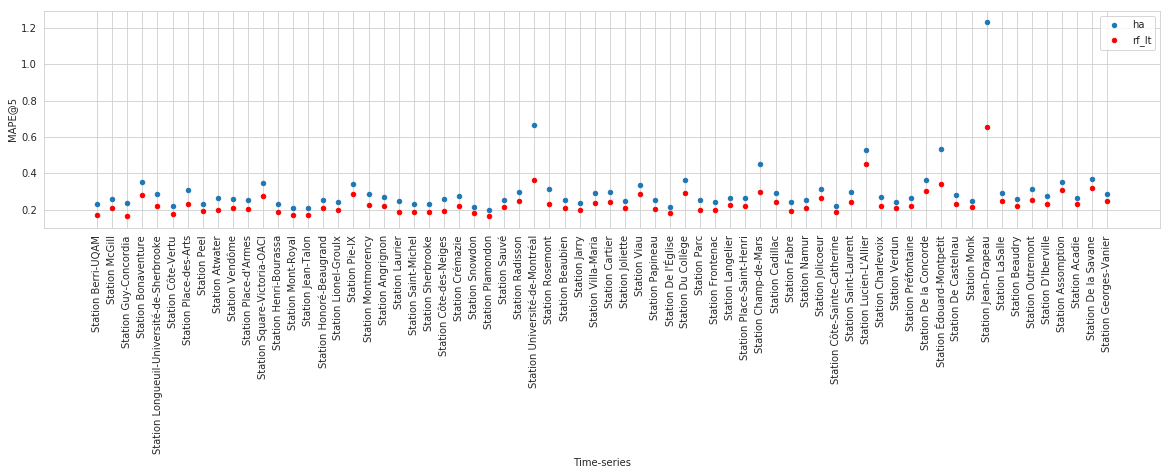

In [68]:
sns.set_style('whitegrid')
ax = plt.gca()
kind = 'scatter'

f = df_train_error_per_station.plot(figsize = (20,4), kind=kind, x='__index__', y='ha', ax=ax )
f = df_train_error_per_station.plot(kind=kind, x='__index__', y='rf_lt', ax=ax, color='red')
f.set_xticks(df_train_error_per_station['__index__'])
f.set_xticklabels(df_train_error_per_station['__time_series__'], rotation=90)
f.set_xlabel('Time-series')
f.set_ylabel('MAPE@'+str(AT))

ax.legend(['ha','rf_lt'],)
plt.show()

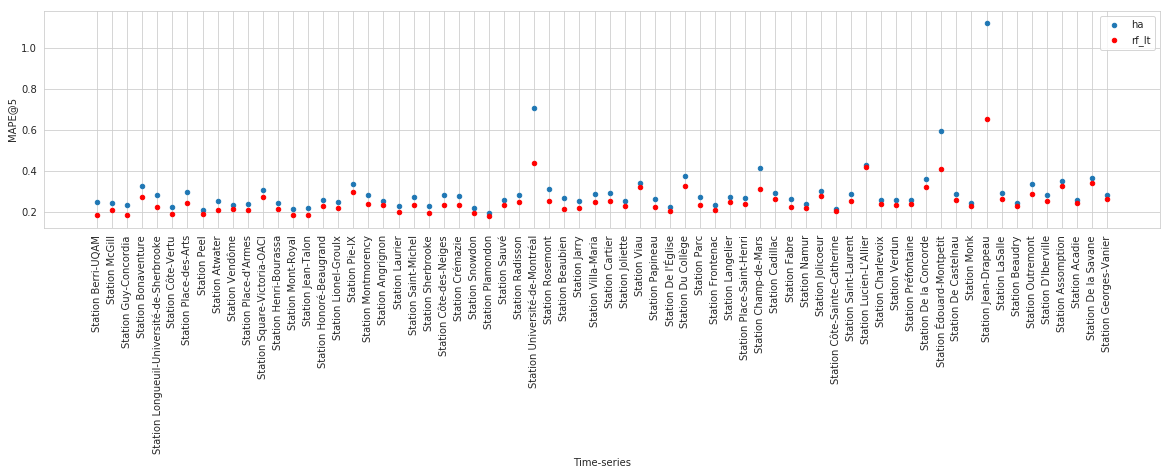

In [69]:
sns.set_style('whitegrid')
ax = plt.gca()
kind = 'scatter'

f = df_test_error_per_station.plot(figsize = (20,4), kind=kind, x='__index__', y='ha', ax=ax )
f = df_test_error_per_station.plot(kind=kind, x='__index__', y='rf_lt', ax=ax, color='red')
f.set_xticks(df_test_error_per_station['__index__'])
f.set_xticklabels(df_test_error_per_station['__time_series__'], rotation=90)
f.set_xlabel('Time-series')
f.set_ylabel('MAPE@'+str(AT))

ax.legend(['ha','rf_lt'],)
plt.show()